In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [ ]:
!pip install -q tensorflow-io
!pip install pydicom
!pip install scikit-image

In [113]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import tensorflow as tf
import tensorflow_io as tfio

In [114]:
train_csv = pd.read_csv("/kaggle/input/osic-pulmonary-fibrosis-progression/train.csv")
test_csv = pd.read_csv("/kaggle/input/osic-pulmonary-fibrosis-progression/test.csv")
print("TRAIN DATA: \n", train_csv.head())
print("TEST DATA: \n", test_csv.head())

TRAIN DATA: 
                      Patient  Weeks   FVC    Percent  Age   Sex SmokingStatus
0  ID00007637202177411956430     -4  2315  58.253649   79  Male     Ex-smoker
1  ID00007637202177411956430      5  2214  55.712129   79  Male     Ex-smoker
2  ID00007637202177411956430      7  2061  51.862104   79  Male     Ex-smoker
3  ID00007637202177411956430      9  2144  53.950679   79  Male     Ex-smoker
4  ID00007637202177411956430     11  2069  52.063412   79  Male     Ex-smoker
TEST DATA: 
                      Patient  Weeks   FVC    Percent  Age   Sex SmokingStatus
0  ID00419637202311204720264      6  3020  70.186855   73  Male     Ex-smoker
1  ID00421637202311550012437     15  2739  82.045291   68  Male     Ex-smoker
2  ID00422637202311677017371      6  1930  76.672493   73  Male     Ex-smoker
3  ID00423637202312137826377     17  3294  79.258903   72  Male     Ex-smoker
4  ID00426637202313170790466      0  2925  71.824968   73  Male  Never smoked


In [115]:
print("Number of examples in Train data: ", len(train_csv))
print("Number of examples in Test data: ", len(test_csv))

num_patients = len(train_csv.Patient.unique())
print("\nNumber of unique patients: ", num_patients)

Number of examples in Train data:  1549
Number of examples in Test data:  5

Number of unique patients:  176


In [116]:
train_data = train_csv.groupby("Patient")
first_occurrence = train_data.first()

Lowest Age:  49
Highest Age:  88


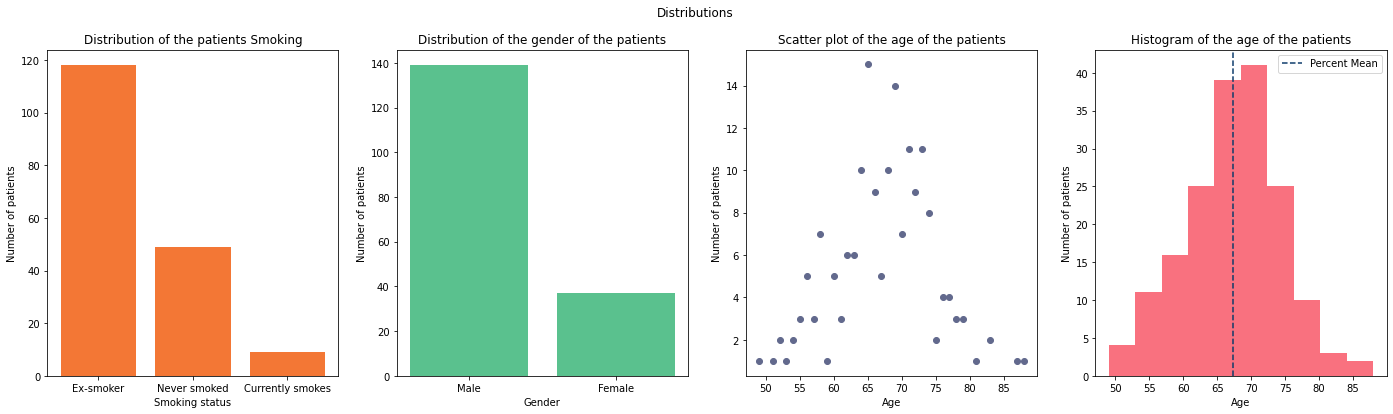

In [124]:
## DEMOGRAPHICS OF PATIENTS

# SMOKING STATUS 
smoking_status = first_occurrence["SmokingStatus"]
smoking_labels = smoking_status.value_counts().index.tolist()
smoking_counts = smoking_status.value_counts().tolist()

# SEX
gender_status = first_occurrence["Sex"]
gender_labels = gender_status.value_counts().index.tolist()
gender_counts = gender_status.value_counts().tolist()

# AGE
age = first_occurrence["Age"]
age_labels = age.value_counts().index.tolist()
age_counts = age.value_counts().tolist()

print("Lowest Age: ", age.min())
print("Highest Age: ", age.max())

# PLOTTING THE DISTRIBUTIONS
fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize = (24, 6))

ax1.bar([1,2,3], smoking_counts, tick_label=smoking_labels, color="#f37735")
ax1.set_title("Distribution of the patients Smoking")
ax1.set_xlabel("Smoking status")
ax1.set_ylabel("Number of patients")

ax2.bar([1,2], gender_counts, tick_label=gender_labels, color="#5ac18e")
ax2.set_title("Distribution of the gender of the patients")
ax2.set_xlabel("Gender")
ax2.set_ylabel("Number of patients")

ax3.scatter(age_labels, age_counts, color="#62698d")
ax3.set_title("Scatter plot of the age of the patients")
ax3.set_xlabel("Age")
ax3.set_ylabel("Number of patients")

ax4.hist(age.tolist(), bins=10, color="#f9717f")
ax4.axvline(age.mean(), label="Age Mean", color="#0c3b6a", linestyle='--')
ax4.set_title("Histogram of the age of the patients")
ax4.set_xlabel("Age")
ax4.set_ylabel("Number of patients")
ax4.legend()

fig.suptitle("Distributions")
plt.show()

Max FVC value:  6399
Min FVC value:  827
Mean FVC value:  2690.479018721756

Max Percent value:  153.145377828922
Min Percent value:  28.877576671694303
Mean Percent value:  77.67265350296324

Max week:  133
Min week:  -5
Mean number of week:  31.861846352485475


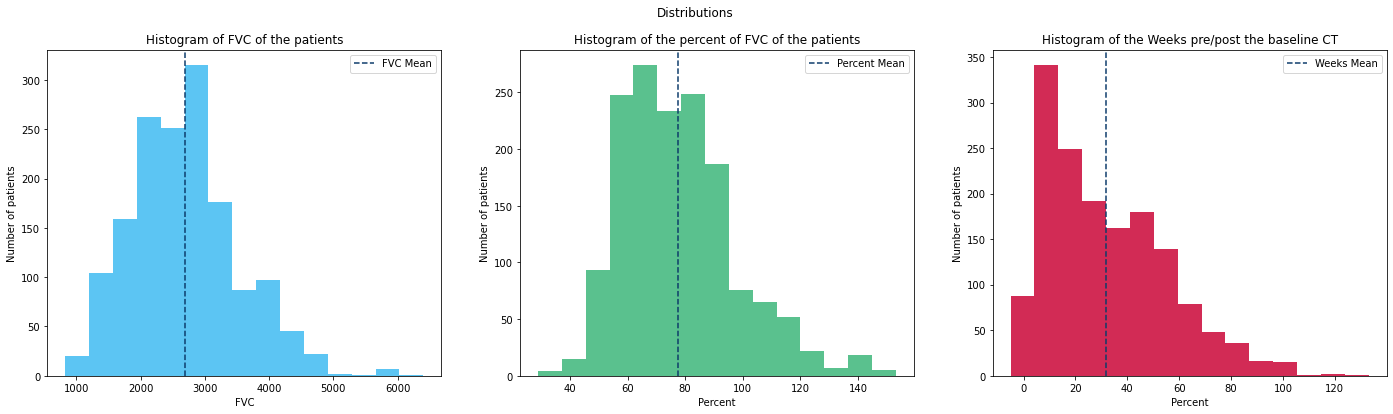

In [125]:
# HISTOGRAMS

# FVC - the recorded lung capacity in ml
fvc = train_csv["FVC"]

print("Max FVC value: ", fvc.max())
print("Min FVC value: ", fvc.min())
print("Mean FVC value: ", fvc.mean())

# PERCENT -  a computed field which approximates the patient's FVC as a percent of the typical FVC for a person of similar characteristics
percent = train_csv["Percent"]

print("\nMax Percent value: ", percent.max())
print("Min Percent value: ", percent.min())
print("Mean Percent value: ", percent.mean())

# WEEKS - the relative number of weeks pre/post the baseline CT
weeks = train_csv["Weeks"]

print("\nMax week: ", weeks.max())
print("Min week: ", weeks.min())
print("Mean number of week: ", weeks.mean())


# PLOTTING THE HISTOGRAMS
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize = (24, 6))

ax1.hist(fvc.tolist(), bins=15, color="#5cc5f3")
ax1.axvline(fvc.mean(), label="FVC Mean", color="#0c3b6a", linestyle='--')
ax1.set_title("Histogram of FVC of the patients")
ax1.set_xlabel("FVC")
ax1.set_ylabel("Number of patients")
ax1.legend()

ax2.hist(percent.tolist(), bins=15, color="#5ac18e")
ax2.axvline(percent.mean(), label="Percent Mean", color="#0c3b6a", linestyle='--')
ax2.set_title("Histogram of the percent of FVC of the patients")
ax2.set_xlabel("Percent")
ax2.set_ylabel("Number of patients")
ax2.legend()

ax3.hist(weeks.tolist(), bins=15, color="#d22b55")
ax3.axvline(weeks.mean(), label="Weeks Mean", color="#0c3b6a", linestyle='--')
ax3.set_title("Histogram of the Weeks pre/post the baseline CT")
ax3.set_xlabel("Percent")
ax3.set_ylabel("Number of patients")
ax3.legend()

fig.suptitle("Distributions")
plt.show()

In [ ]:
filename = '/kaggle/input/osic-pulmonary-fibrosis-progression/test/ID00422637202311677017371/45.dcm'
image_bytes = tf.io.read_file(filename)

image = tfio.image.decode_dicom_image(image_bytes, dtype=tf.uint16)
skipped = tfio.image.decode_dicom_image(image_bytes, on_error='skip', dtype=tf.uint8)
lossy_image = tfio.image.decode_dicom_image(image_bytes, scale='auto', on_error='lossy', dtype=tf.uint8)


fig, axes = plt.subplots(1,2, figsize=(10,10))
axes[0].imshow(np.squeeze(image.numpy()), cmap='gray')
axes[0].set_title('image')
axes[1].imshow(np.squeeze(lossy_image.numpy()), cmap='gray')
axes[1].set_title('lossy image');